# Определение факторов успешности игр

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение и предобработка данных

Осуществляется загрузка необходимых библиотек.

In [1]:
import pandas as pd #загружаем библиотеку pandas
import numpy as np #загружаем библиотеку numpy
import seaborn as sns #загружаем библиотеку seaborn
import matplotlib.pyplot as plt #загружаем matplotlib.pyplot
from scipy import stats as st #загружаем stats из библиотеки scipy

Осуществляется загрузка файла games.csv и первичное знакомство с данными.

In [2]:
data = pd.read_csv('/datasets/games.csv') #считываем csv-файл

data.info() #смотрим сводку основной информации
data.head() #смотрим как отображаются данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Первичный обзор файла показывает, что в данных есть пропуска, а названия столбцов написаны в разном регистре.

Для начала приведем названия столбцов к нижнему регистру. 

In [3]:
data.columns = data.columns.str.lower() #задаем нижний регистр в названии столбцов

Проверим результат.

In [4]:
data.head() #смотрим как отображаются данные

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Регистр успешно изменен.

Мы видим, что в базе есть две игры без названия. Это странно, посмотрим на информацию по ним.

In [5]:
data[data['name'].isna()] #выведем строки без названия игры 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Неудивительно, что по этим играм также отсутствуют жанры и оценки (хотя есть какие-то значения продаж). Предлагается удалить их из базы. Также предлагается удалить из базы игры с неуказанным годом выпуска (так как их относительно немного, а год, скорее всего, будет важен для анализа). 

In [6]:
data = data.dropna(subset=['name', 'year_of_release']) #удалим строки без названия или года выпуска игры

Проверим результат.

In [7]:
data.info() #смотрим сводку основной информации

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Оставшихся пропусков слишком много, чтобы просто удалять их, поэтому далее каждый столбец будет рассмотрен отдельно. 

### Столбец name

Проверим количество уникальных значений в столбце name.

In [8]:
len(data['name'].unique()) #рассчитаем количество уникальных названий

11426

Уникальных названий меньше, чем строк в таблице. Значит ли это, что в базе есть повторы? Посмотрим на повторяющиеся значения.

In [9]:
data['name'].value_counts() #посчитаем число для каждого названия

Need for Speed: Most Wanted                      12
FIFA 14                                           9
Ratatouille                                       9
LEGO Marvel Super Heroes                          9
LEGO Star Wars II: The Original Trilogy           8
                                                 ..
Virtua Tennis: World Tour (US & Others sales)     1
World Cup '98 France: Road to Win                 1
One Piece: Super Grand Battle! X                  1
Aero Gauge                                        1
Silent Hunter 5: Battle of the Atlantic           1
Name: name, Length: 11426, dtype: int64

Need for Speed: Most Wanted встречается целых 12 раз. Почему? Выведем детальную информацию.

In [10]:
data[data['name'] == 'Need for Speed: Most Wanted'] #выведем строки c игрой Need for Speed: Most Wanted

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Теперь понятно - это версии одной игры, но на разных платформах/в разных изданиях. Будем иметь в виду.

### Столбец platform

Теперь посмотрим на уникальные значения в столбце platform.

In [11]:
data['platform'].unique() #выведем уникальные значения в столбце platform

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Кажется, что здесь все выглядит нормально.

### Столбец year_of_release

Теперь посмотрим на уникальные значения в столбце year_of_release.

In [12]:
np.sort(data['year_of_release'].unique()) #выведем уникальные отсортированные значения в столбце year_of_release

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.])

Данные есть за каждый год с 1980 по 2016. Так как в данных присутствует только год, можно просто перевести столбец в целочисленный формат.

In [13]:
data['year_of_release'] = data['year_of_release'].astype('int') #переводим данные в целочисленный формат в столбце year_of_release

Проверим результат.

In [14]:
data.info() #смотрим сводку основной информации
data.head() #смотрим как отображаются данные

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Тип столбца успешно изменен.

### Столбец genre

Теперь посмотрим на уникальные значения в столбце genre.

In [15]:
data['genre'].unique() #выведем уникальные значения в столбце genre

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

Кажется, что здесь тоже все выглядит нормально.

### Столбец critic_score

Теперь посмотрим на уникальные значения в столбце critic_score.

In [16]:
data['critic_score'].unique() #выведем уникальные значения в столбце critic_score

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

Оценки критиков все целочисленные, но наличие пропусков не дает изменить тип столбца.

### Столбец user_score

Теперь посмотрим на уникальные значения в столбце user_score.

In [17]:
data['user_score'].unique() #выведем уникальные значения в столбце user_score

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо числовых значений, в данном столбце присутствует запись tbd - вероятно, она означает "to be done" (то есть оценка еще не определена). С точки зрения нашего анализа, это по сути - пропуска, и лучше заменить их на NaN, это потенциально позволит корректно проводить со значениями рассматриваемого столбца некоторые математические операции.

In [18]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan #заменяем значения tbd на nan в столбце user_score

Теперь можно поменять формат столбца на числовой. 

In [19]:
data['user_score'] = data['user_score'].astype('float') #переводим данные в формат числа с плавающей точкой в столбце user_score

Проверим результат.

In [20]:
data.info() #смотрим сводку основной информации

data['user_score'].unique() #выведем уникальные значения в столбце user_score

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

Тип столбца успешно изменен, а значения tbd больше не встречаются.  

### Столбец rating

Теперь посмотрим на уникальные значения в столбце rating.

In [21]:
data['rating'].unique() #выведем уникальные значения в столбце rating

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Кажется, что здесь тоже все выглядит нормально.

### Столбец na_sales

Смотреть на уникальные значения в столбцах с продажами не имеет смысла - все это дробные величины без пропусков. Вместо этого посмотрим для столбца na_sales описательную статистику.

In [22]:
data['na_sales'].describe() #смотрим описание значений в столбце na_sales

count    16444.000000
mean         0.264012
std          0.818378
min          0.000000
25%          0.000000
50%          0.080000
75%          0.240000
max         41.360000
Name: na_sales, dtype: float64

Максимум выглядит выбивающимся на фоне остальных значений, но, вероятно, является нормальным для "топовых" игр. Нулевые значения также адекватны для отдельных рынков (некоторые игры, например, продаются только в Японии), либо, возможно, могут являться округлением очень малых величин. 

### Столбец eu_sales

Теперь посмотрим на описательную статистику для столбца eu_sales.

In [23]:
data['eu_sales'].describe() #смотрим описание значений в столбце eu_sales

count    16444.000000
mean         0.145930
std          0.506716
min          0.000000
25%          0.000000
50%          0.020000
75%          0.110000
max         28.960000
Name: eu_sales, dtype: float64

Кажется, что здесь тоже все выглядит нормально.

### Столбец jp_sales

Теперь посмотрим на описательную статистику для столбца jp_sales.

In [24]:
data['jp_sales'].describe() #смотрим описание значений в столбце jp_sales

count    16444.000000
mean         0.078487
std          0.311100
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max         10.220000
Name: jp_sales, dtype: float64

Кажется, что здесь тоже все выглядит нормально.

### Столбец other_sales

Теперь посмотрим на описательную статистику для столбца other_sales.

In [25]:
data['other_sales'].describe() #смотрим описание значений в столбце other_sales

count    16444.000000
mean         0.047594
std          0.188005
min          0.000000
25%          0.000000
50%          0.010000
75%          0.030000
max         10.570000
Name: other_sales, dtype: float64

Кажется, что здесь тоже все выглядит нормально.

На всякий случай проверим таблицу на явные дубликаты.

In [26]:
data.duplicated().sum() #найдем количество строк-дубликатов

0

Дубликаты не обнаружены.

Затем посчитаем суммарные продажи во всех регионах для каждой игры.

In [27]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales'] #добавляем столбец с суммой всех продаж

Проверим результат.

In [28]:
data.info() #смотрим сводку основной информации
data.head() #смотрим как отображаются данные

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
 11  all_sales        16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Новый столбец успешно добавлен в таблицу, расчеты произведены корректно.

## Исследовательский анализ данных

Посмотрим - сколько игр выпускалось в различные годы. Построим столбчатую диаграмму на основе сводной таблицы.

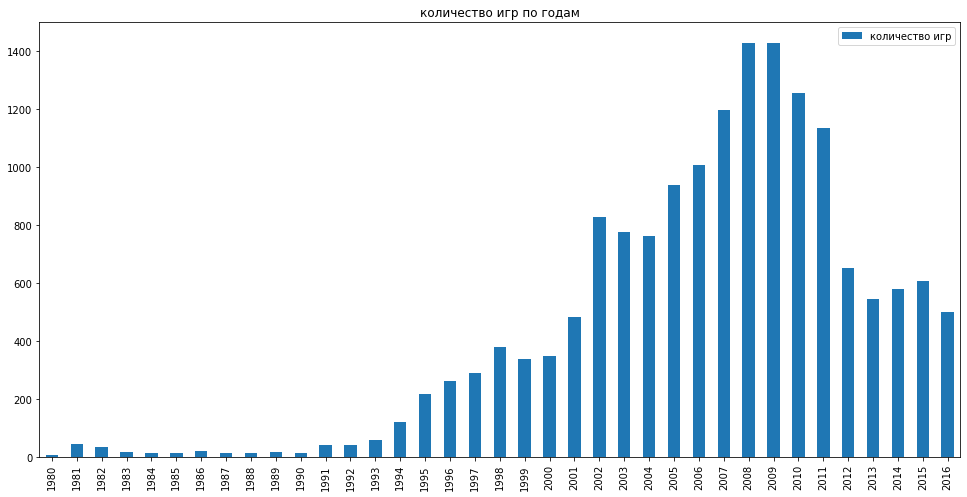

In [29]:
data.pivot_table(index='year_of_release', values='name', aggfunc='count').plot.bar(figsize=(16.5, 8)) #строим диаграмму на основе сводной таблицы с группировкой числа игр по году выпуска
plt.title('количество игр по годам') #добавляем название
plt.xlabel('') #убираем лишние названия осей
plt.legend(['количество игр']) #добавляем легенду

Относительно значимый рост игрового рынка начался примерно с 1991 года, а объем продаж вышел на уровень текущего рассматриваемого периода (то есть 2016 года) в 2001 году, затем был продолжающийся бурный подъем с пиком в 2008-2009 годах и последующий спад. При этом следует также отметить, что в последние 5 лет рынок находился в определенном "застое". 

Далее выберем платформы с наибольшими суммарными продажами. Для этого снова построим столбчатую диаграмму на основе сводной таблицы.

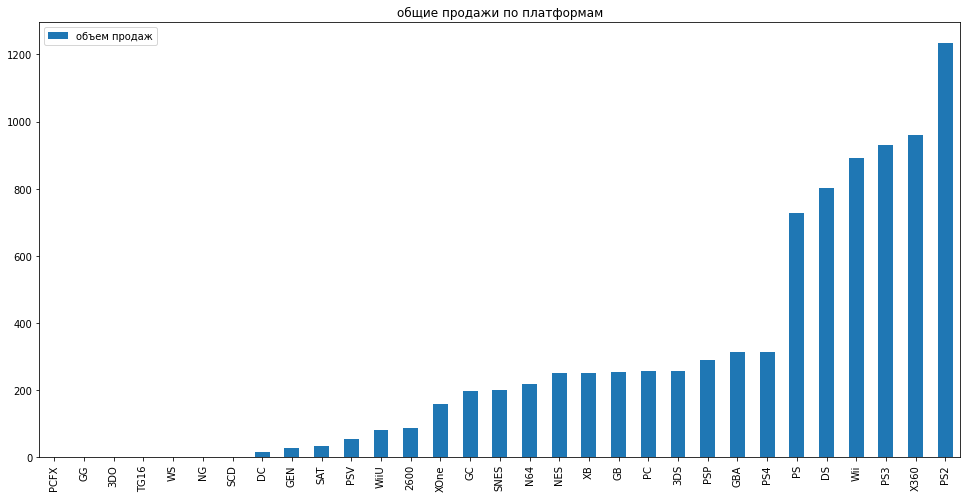

In [30]:
data.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values('all_sales').plot.bar(figsize=(16.5, 8)) #строим диаграмму на основе сводной таблицы с группировкой и сортировкой суммы общих продаж по игровым платформам
plt.title('общие продажи по платформам') #добавляем название
plt.xlabel('') #убираем лишние названия осей
plt.legend(['объем продаж']) #добавляем легенду

В части общего объема продаж явно лидируют шесть платформ: PS, DS, Wii, PS3, X360 и PS2. Для этих платформ также построим распределение продаж по годам (для удобства сделаем это на одном графике).

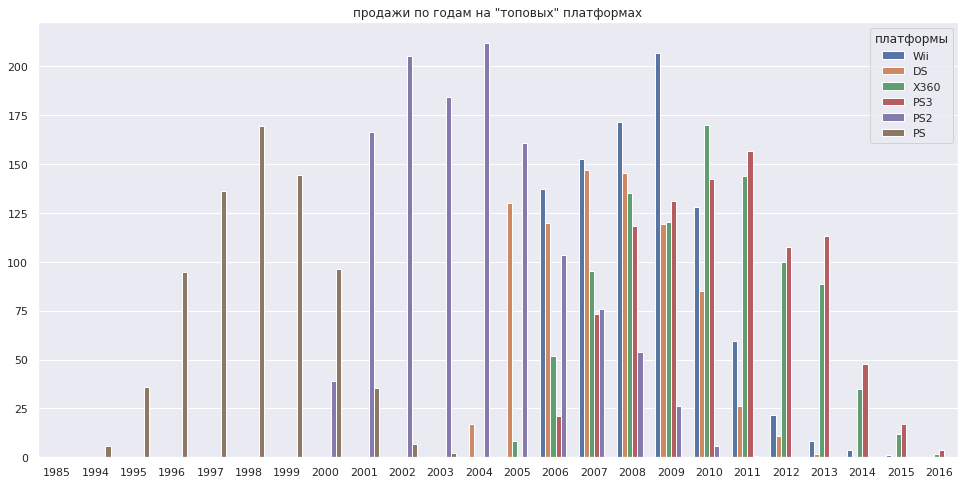

In [31]:
top_platforms = ['PS', 'DS', 'Wii', 'PS3', 'X360', 'PS2'] #создаем список "топовых" платформ

sns.set(rc = {'figure.figsize':(16.5, 8)}) #настраиваем размер диаграммы
sns.barplot(x='year_of_release', y='all_sales', hue='platform', data=data.query('platform in @top_platforms'), ci=None, estimator=sum) #строим диаграмму с разбивкой по платформам из списка
plt.title('продажи по годам на "топовых" платформах') #добавляем название
plt.xlabel('') #убираем лишние названия осей
plt.ylabel('') #убираем лишние названия осей
plt.legend(title='платформы', loc='upper right') #добавляем легенду

Можно сказать, что средний жизненный цикл платформы - это примерно 10 лет (даже если платформа существует на 1-2 года дольше, продажи в последние периоды существенно падают). При этом все шесть самых популярных когда-либо платформ заметно сдают позиции (или вовсе выходят из оборота) к 2016 году.

С учетом вышесказанного, наиболее актуальными с точки зрения анализа, вероятно, будут данные за последние 5 лет - они отсекут уже устаревающие платформы и в целом будут представлять сложившееся рыночное "плато" по количеству игр.

In [32]:
data = data.query('year_of_release >= 2012') #выбираем записи за последние 5 лет

data.info() #смотрим сводку основной информации

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2886 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2886 non-null   object 
 1   platform         2886 non-null   object 
 2   year_of_release  2886 non-null   int64  
 3   genre            2886 non-null   object 
 4   na_sales         2886 non-null   float64
 5   eu_sales         2886 non-null   float64
 6   jp_sales         2886 non-null   float64
 7   other_sales      2886 non-null   float64
 8   critic_score     1312 non-null   float64
 9   user_score       1531 non-null   float64
 10  rating           1611 non-null   object 
 11  all_sales        2886 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 293.1+ KB


Посмотрим на платформы с наибольшим числом продаж в 2016 году.

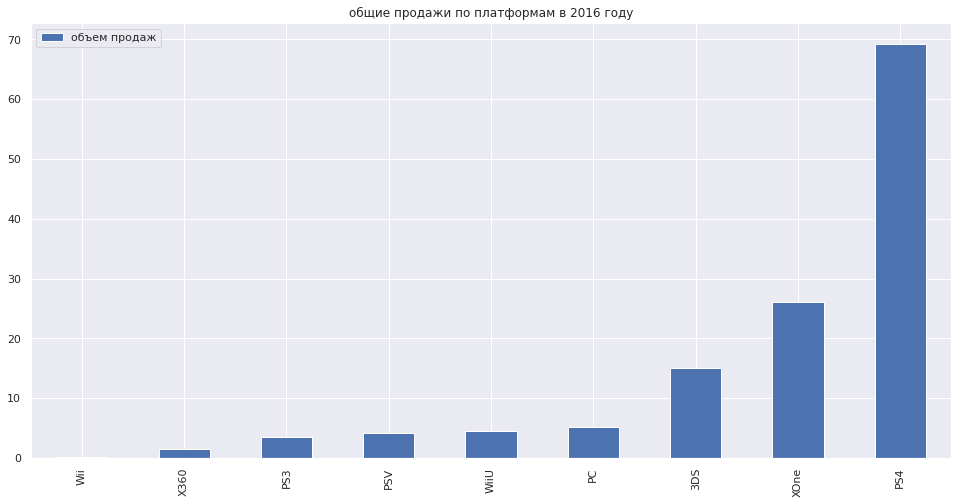

In [33]:
data[data['year_of_release'] == 2016].pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values('all_sales').plot.bar(figsize=(16.5, 8)) #строим диаграмму на основе сводной таблицы с группировкой и сортировкой суммы общих продаж по игровым платформам в 2016 году
plt.title('общие продажи по платформам в 2016 году') #добавляем название
plt.xlabel('') #убираем лишние названия осей
plt.legend(['объем продаж']) #добавляем легенду

В рассматриваемый период явно лидирует PS4, на втором и третьем местах - Xbox One и 3DS соответственно, но для каких-либо выводов надо также оценить динамику продаж на указанных платформах за последние годы.

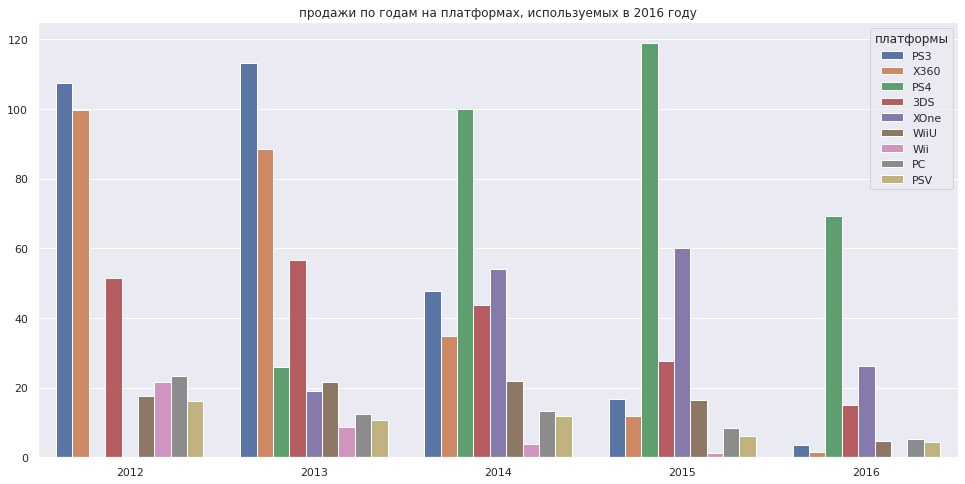

In [34]:
paltforms_2016 = data[data['year_of_release'] == 2016]['platform'].unique() #создаем список платформ, используемых в 2016 году

sns.set(rc = {'figure.figsize':(16.5, 8)}) #настраиваем размер диаграммы
sns.barplot(x='year_of_release', y='all_sales', hue='platform', data=data.query('platform in @paltforms_2016'), ci=None, estimator=sum) #строим диаграмму с разбивкой по платформам из списка
plt.title('продажи по годам на платформах, используемых в 2016 году') #добавляем название
plt.xlabel('') #убираем лишние названия осей
plt.ylabel('') #убираем лишние названия осей
plt.legend(title='платформы', loc='upper right') #добавляем легенду

Лидирующие PS4 и Xbox One, похоже, находятся в первой половине своего жизненного цикла, а вот 3DS, наоборот - во второй, поэтому вместо нее в качестве перспективной платформы лучше рассматривать PC, который хоть и падает в части объема продаж игр, присутствует во все рассматриваемые года и, скорее всего, в любом случае останется на рынке ввиду своей разносторонней функциональности.  

In [35]:
top_platforms_2016 = ['PS4', 'XOne', 'PC'] #создаем список потенциально прибыльных платформ

Посмотрим диаграмму "ящик с усами" по выбранным платформам.

Text(0, 0.5, 'платформы')

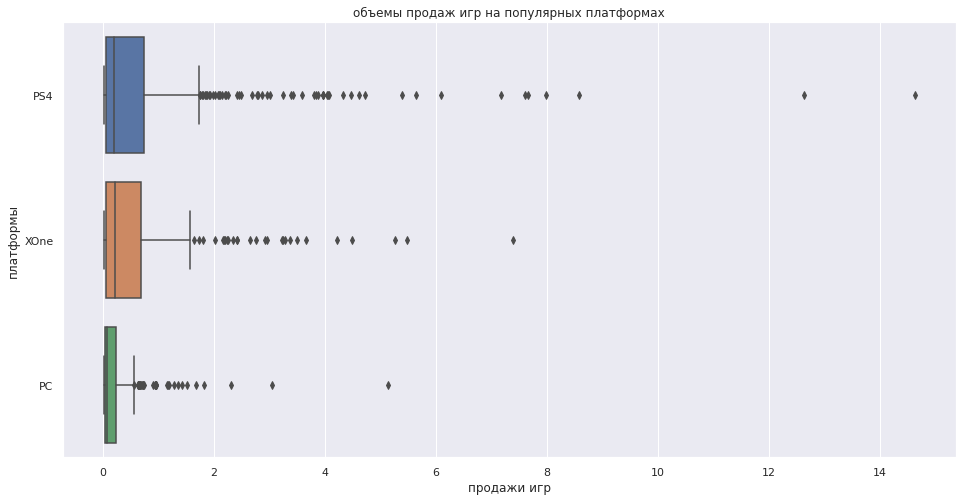

In [36]:
sns.set(rc = {'figure.figsize':(16, 8)}) #настраиваем размер диаграммы
sns.boxplot(x='all_sales', y='platform', data=data.query('platform in @top_platforms_2016')) #строим диаграмму с разбивкой по платформам из списка
plt.title('объемы продаж игр на популярных платформах') #добавляем название
plt.xlabel('продажи игр') #называем оси
plt.ylabel('платформы') #называем оси

В случае PS4 вы наблюдаем значительное число "выбросов" с высоким объемом продаж и достаточно большой межквартильный размах. В случае Xbox One "выбросов" чуть меньше, но межквартильный размах такой же большой. А вот для PC разброс значений (как и сами значения в основной своей массе) гораздо ниже, а "выбросы" сгруппированы более кучно у правого/верхнего "уса". Такой факт может объясняться наличием эксклюзивных игр и игр, "заточенных" специально под одну из платформ-приставок, в то время как на компьютерах выходит большинство доступных игр и поэтому их продажи распределены более равномерно.

Далее более подробно рассмотрим влияние отзывов на продажи на примере одной из платформ (возьмем PS4).

,all_sales,critic_score,user_score
all_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


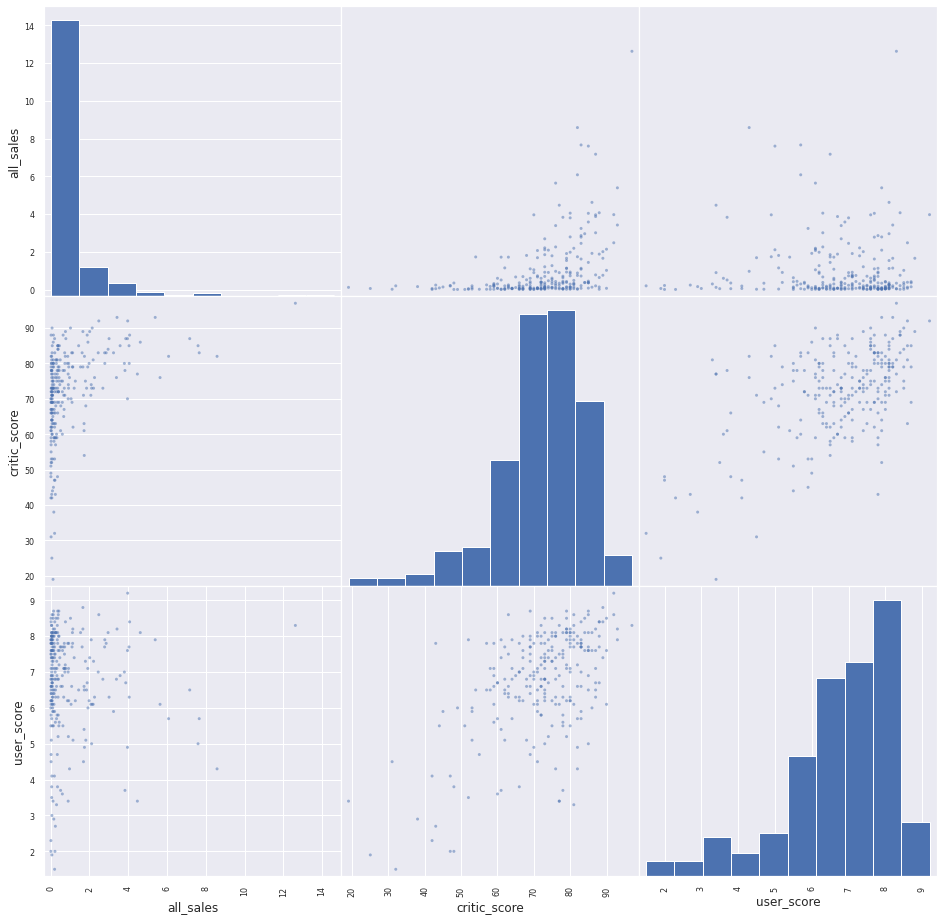

In [37]:
data_ps4 = data.loc[data['platform'] == 'PS4', ['all_sales', 'critic_score', 'user_score']] #выбираем нужные записи, относящиеся к PS4

display(data_ps4.corr()) #строим матрицу корреляции
pd.plotting.scatter_matrix(data_ps4, figsize=(16, 16)) #строим матрицу диаграмм рассеивания
None

Объемы продаж игр имеют среднюю зависимость от оценок критиков (коэффициент корреляции примерно 0.4) и, как ни странно, практически не зависят от оценок пользователей (коэффициент корреляции близок к 0). Действительно, диаграмма рассеивания показывает, что встречаются как отдельные игры с низким пользовательским рейтингом и высоким объемом продаж, так и масса игр с высоким рейтингом и низким объемом продаж. Видимо, сказывается разнородность вкусов игроков и рыночных ниш - с одной стороны есть успешные "инди"-проекты со слабым маркетингом, с другой - провальные проекты известных компаний, которые все равно купят.

Проверим выявленные закономерности на других популярных платформах (Xbox One и PC).

,all_sales,critic_score,user_score
all_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


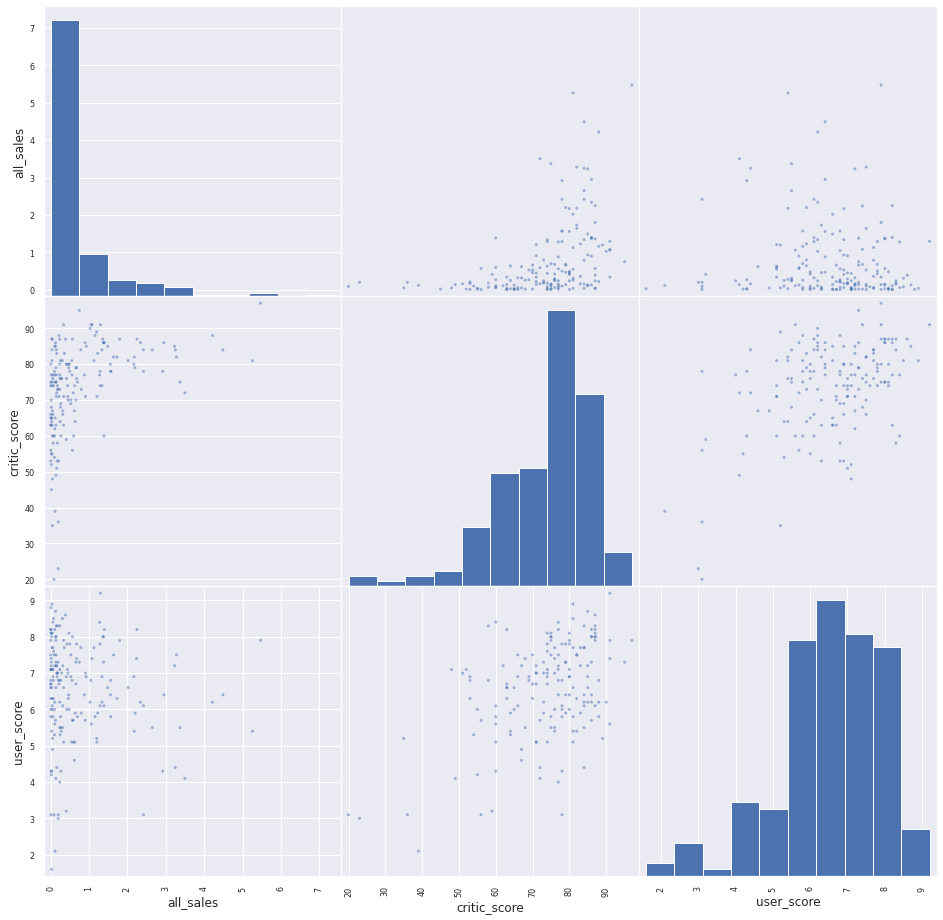

In [38]:
data_xone = data.loc[data['platform'] == 'XOne', ['all_sales', 'critic_score', 'user_score']] #выбираем нужные записи, относящиеся к Xbox One

display(data_xone.corr()) #строим матрицу корреляции
pd.plotting.scatter_matrix(data_xone, figsize=(16, 16)) #строим матрицу диаграмм рассеивания
None

Результаты для Xbox очень похожи на результаты для PS.

,all_sales,critic_score,user_score
all_sales,1.000000,0.237243,-0.121867
critic_score,0.237243,1.000000,0.432587
user_score,-0.121867,0.432587,1.000000


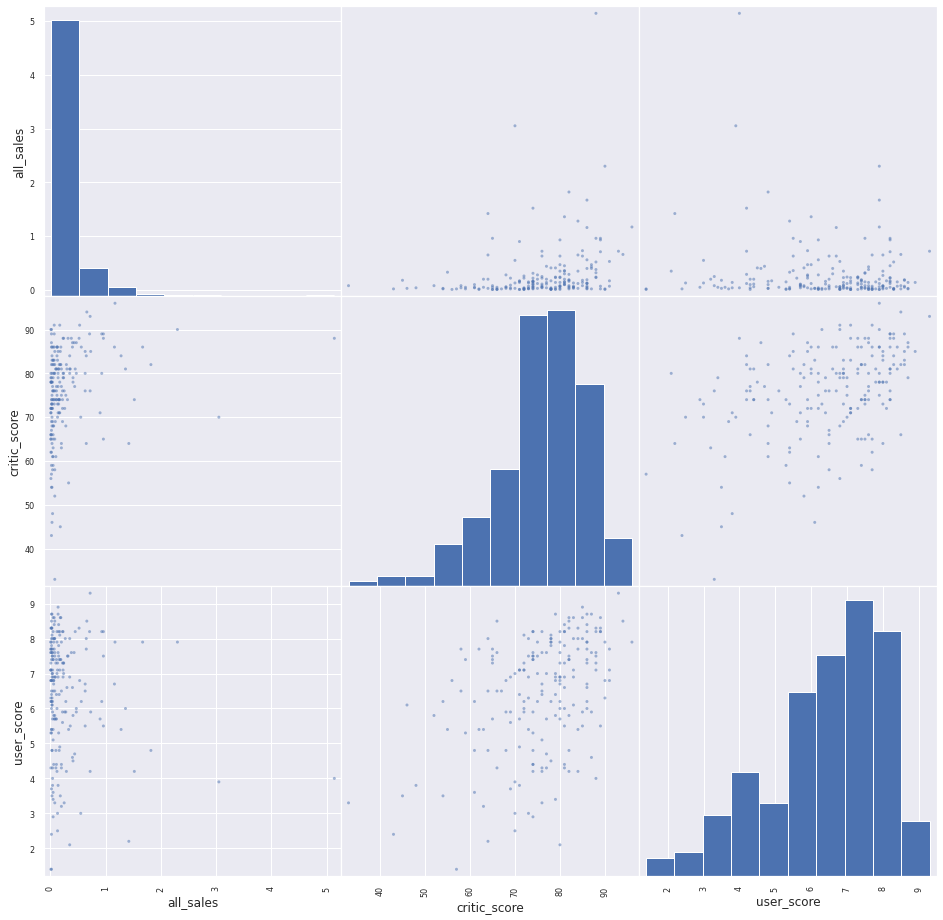

In [39]:
data_pc = data.loc[data['platform'] == 'PC', ['all_sales', 'critic_score', 'user_score']] #выбираем нужные записи, относящиеся к PC

display(data_pc.corr()) #строим матрицу корреляции
pd.plotting.scatter_matrix(data_pc, figsize=(16, 16)) #строим матрицу диаграмм рассеивания
None

В случае PC связь продаж с оценками критиков еще слабее (коэффициент корреляции примерно 0.24), чем на приставках.

Теперь посмотрим на распределение числа игр по жанрам.

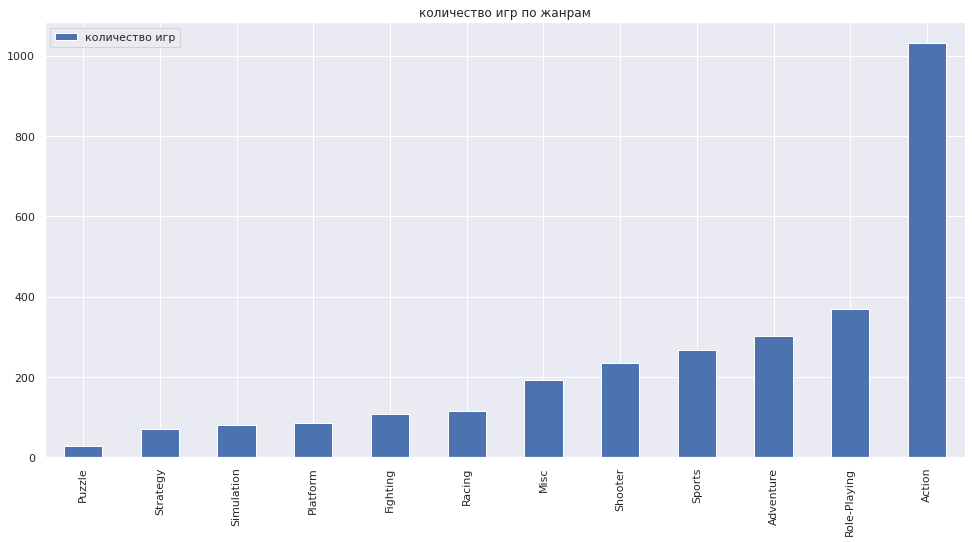

In [41]:
data.pivot_table(index='genre', values='name', aggfunc='count').sort_values('name').plot.bar(figsize=(16.5, 8)) #строим диаграмму на основе сводной таблицы с группировкой числа игр по жанру
plt.title('количество игр по жанрам') #добавляем название
plt.xlabel('') #убираем лишние названия осей
plt.legend(['количество игр']) #добавляем легенду

Больше всего выходит игр в жанрах "экшен", РПГ или приключений, меньше всего - пазлов, стратегий и симуляторов. Посмотрим теперь как это соотносится с объемами продаж по жанрам.

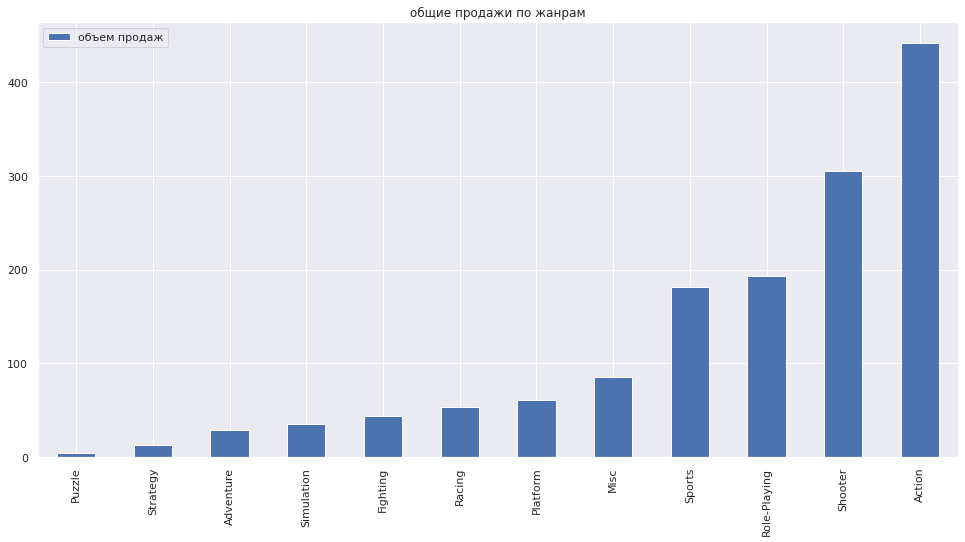

In [42]:
data.pivot_table(index='genre', values='all_sales', aggfunc='sum').sort_values('all_sales').plot.bar(figsize=(16.5, 8)) #строим диаграмму на основе сводной таблицы с группировкой и сортировкой суммы общих продаж по жанру
plt.title('общие продажи по жанрам') #добавляем название
plt.xlabel('') #убираем лишние названия осей
plt.legend(['объем продаж']) #добавляем легенду

С одной стороны, по некоторым жанрам объемы продаж соответствуют числу игр: так, "экшены" и ролевые игры и производятся и продаются в больших количествах, а стратегии и пазлы - в малых. С другой стороны, шутеры имеют большие объемы продаж при среднем числе игр (видимо, все сводится к нескольким популярным сериям шутеров), а приключения, наоборот, продаются не так активно при высоком разнообразии игр (здесь, напротив, может быть много "инди"-тайтлов).

В связи с таким распределением, предлагается также посмотреть на медианные продажи для каждого жанра.

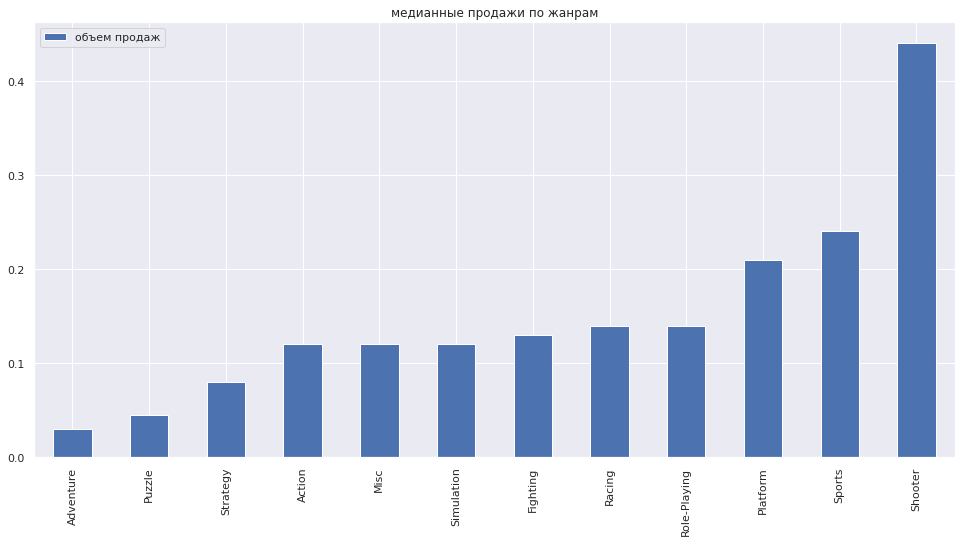

In [43]:
data.pivot_table(index='genre', values='all_sales', aggfunc='median').sort_values('all_sales').plot.bar(figsize=(16.5, 8)) #строим диаграмму на основе сводной таблицы с группировкой и сортировкой медианных продаж по жанру
plt.title('медианные продажи по жанрам') #добавляем название
plt.xlabel('') #убираем лишние названия осей
plt.legend(['объем продаж']) #добавляем легенду

Медианные значения продаж показывают, что потенциально наиболее прибыльными жанрами являются шутеры и спортивные игры.

## Составление портрета пользователя

Для составления портретов пользователей по регионам также предлагается ориентироваться на данные за последние 5 лет, так как предпочтения на рынке игр довольно быстро меняются и лучше полагаться на наиболее актуальные тренды.

Посмотрим на самые популярные платформы в различных регионах.

In [44]:
regions = ['na_sales', 'eu_sales', 'jp_sales'] #составим список с регионами продаж

data_regions_platforms = data.pivot_table(index='platform', values=regions, aggfunc='sum') #строим сводную таблицу с группировкой суммы продаж в каждом регионе по платформам

data_regions_platforms #посмотрим на результат

,eu_sales,jp_sales,na_sales
platform,,,
3DS,42.64,87.79,55.31
DS,3.53,3.72,4.59
PC,37.76,0.00,19.12
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
PSP,0.42,10.47,0.13
PSV,11.36,21.04,10.98
Wii,11.92,3.39,17.45
WiiU,25.13,13.01,38.10


Для удобства построим "пирожковые" диаграммы и укрупним данные, объединив все значения кроме топ-5 для каждого региона в категорию "прочее", воспользовавшись циклом.

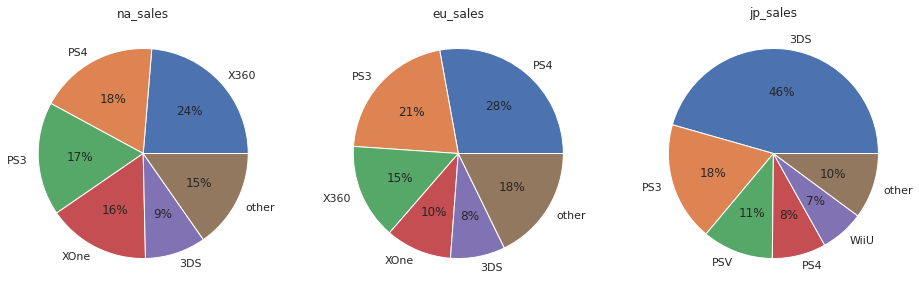

In [45]:
fig, axs = plt.subplots(1, 3) #задаем форму расположения диаграмм
n = 0 #задаем счетчик места расположения диаграммы

for region in regions: #перебираем список регионов
    data_region_platforms_top = data_regions_platforms[region].sort_values(ascending=False).head(5) #для каждого региона находим топ-5 платформ
    data_region_platforms_others = pd.Series(data_regions_platforms[region].sum() - data_region_platforms_top.sum(), ['other']) #находим сумму продаж по остальным платформам...
    data_region_platforms_top = data_region_platforms_top.append(data_region_platforms_others) #...и добавляем ее в top series
    axs[n].pie(data_region_platforms_top, labels=data_region_platforms_top.index, autopct='%.0f%%') #строим диаграмму для каждого региона
    axs[n].title.set_text(region) #добавляем название
    n += 1 #увеличиваем счетчик места

В Северной Америке среди игроков за последние пять лет преобладала платформа X360 (24% всех продаж), которая постепенно уступает место платформам PS4 (18%) и Xbox One (16%). В Европе PS4 уже вырвалась вперед (28%) и даже PS3 (21%) пока существенно обгоняет продукты Xbox. А вот в Японии почти половина продаж игр приходилась на 3DS (46%), на втором месте находится PS3 (18%), а Xbox вообще не представлен в топ-5 - очевидно, сказывается национальная специфика брендов.

Аналогичным образом рассмотрим самые популярные жанры игр в различных регионах.

In [46]:
data_regions_genres = data.pivot_table(index='genre', values=regions, aggfunc='sum') #строим сводную таблицу с группировкой суммы продаж в каждом регионе по жанрам

data_regions_genres #посмотрим на результат

,eu_sales,jp_sales,na_sales
genre,,,
Action,159.34,52.80,177.84
Adventure,9.46,8.24,8.92
Fighting,10.79,9.44,19.79
Misc,26.32,12.86,38.19
Platform,21.41,8.63,25.38
Puzzle,1.40,2.14,1.13
Racing,27.29,2.50,17.22
Role-Playing,48.53,65.44,64.00
Shooter,113.47,9.23,144.77


Построим также диаграммы по укрупненным данным.

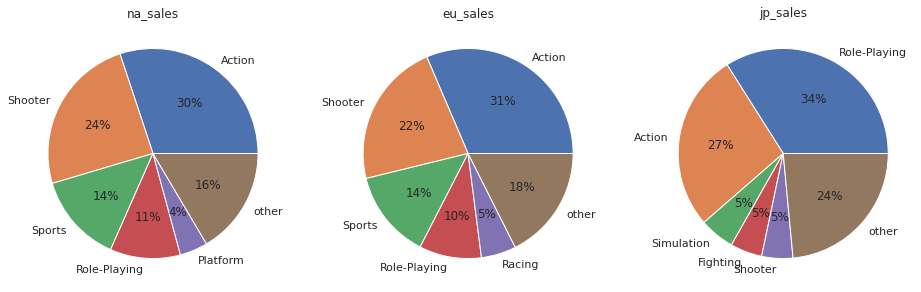

In [47]:
fig, axs = plt.subplots(1, 3) #задаем форму расположения диаграмм
n = 0 #задаем счетчик места расположения диаграммы

for region in regions: #перебираем список регионов
    data_region_genres_top = data_regions_genres[data_regions_genres.index != 'Misc'][region].sort_values(ascending=False).head(5) #для каждого региона находим топ-5 жанров (за исключением misc)
    data_region_genres_others = pd.Series(data_regions_genres[region].sum() - data_region_genres_top.sum(), ['other']) #находим сумму продаж по остальным жанрам...
    data_region_genres_top = data_region_genres_top.append(data_region_genres_others) #...и добавляем ее в top series
    axs[n].pie(data_region_genres_top, labels=data_region_genres_top.index, autopct='%.0f%%') #строим диаграмму для каждого региона
    axs[n].title.set_text(region) #добавляем название
    n += 1 #увеличиваем счетчик места

B Америке и Европе самые популярные жанры распределены схожим образом: на первом месте - "экшены" (30% продаж в Америке и 31% продаж в Европе), на втором - шутеры (24% и 22% соответственно), на третьем - спортивные игры (по 14% в каждом случае), на четвертом - ролевые (11% и 10%). Единственная разница заключается в том, что американцы предпочитают платформеры (4%), а европейцы - гонки (5%). В Японии же "балом правят" ролевые игры (34% продаж), "экшен" находится на втором месте (27%), а дальше с большим отрывом идут симуляторы, файтинги и шутеры (по 5% продаж на каждый жанр).

Далее изучим влияние рейтинга ESRB на продажи в каждом регионе. При этом учтем, что в данных были пропуски и заменим их на условные значения.

In [48]:
data['rating'] = data['rating'].fillna('n/a') #заменяем пропуска в рейтингах на n/a

data_regions_rating = data.pivot_table(index='rating', values=regions, aggfunc='sum') #строим сводную таблицу с группировкой суммы продаж в каждом регионе по рейтингам

data_regions_rating #посмотрим на результат

,eu_sales,jp_sales,na_sales
rating,,,
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
T,52.96,26.02,66.02
n/a,91.50,108.84,103.31


Построим для каждого региона столбчатую диаграмму.

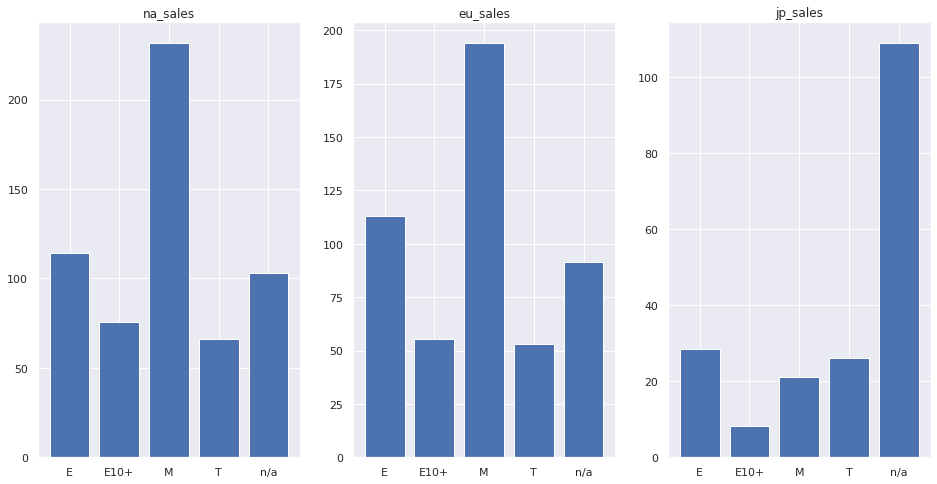

In [49]:
fig, axs = plt.subplots(1, 3) #задаем форму расположения диаграмм
n = 0 #задаем счетчик места расположения диаграммы

for region in regions: #перебираем список регионов
    axs[n].bar(data_regions_rating.index, data_regions_rating[region]) #строим диаграмму для каждого региона
    axs[n].title.set_text(region) #добавляем название
    n += 1 #увеличиваем счетчик места

В Европе и Америке снова схожая ситуация - больше всего игр продается с наиболее "жестким" рейтингом М, остальные варианты достаточно сильно отстают. В Японии же очень много игр без определенного рейтинга (что может быть связано с особенностями выставления рейтинга в этой стране), далее идут "милые" игры с рейтингом Е, а также игры для подростков и взрослых (T и М). Рейтинг Е10+, судя по всему, везде является малопопулярным.

## Проверка гипотез

В ходе исследования надо проверить две гипотезы.

### Первая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые

В этом случае нулевая гипотеза будет сформулирована, исходя из принципа равенства, а альтернативная - как противоположная нулевой:
- h0: средние пользовательские рейтинги платформ Xbox One и PC равны;
- h1: средние пользовательские рейтинги платформ Xbox One и PC не равны.

Для проверки гипотезы разобьем нашу базу данных на две по типу платформы.

In [50]:
data_xone = data.query('platform == "XOne"').dropna(subset=['user_score']) #делаем срез по Xbox One без пропусков в user_score
data_pc = data.query('platform == "PC"').dropna(subset=['user_score']) #делаем срез по PC без пропусков в user_score

data_xone.info() #смотрим сводку основной информации
print() #вставим пустую сроку
data_pc.info() #смотрим сводку основной информации

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 165 to 16660
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             182 non-null    object 
 1   platform         182 non-null    object 
 2   year_of_release  182 non-null    int64  
 3   genre            182 non-null    object 
 4   na_sales         182 non-null    float64
 5   eu_sales         182 non-null    float64
 6   jp_sales         182 non-null    float64
 7   other_sales      182 non-null    float64
 8   critic_score     165 non-null    float64
 9   user_score       182 non-null    float64
 10  rating           182 non-null    object 
 11  all_sales        182 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 18.5+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206 entries, 192 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           ------

Используем t-тест с параметром equal_var (так как полученные под-выборки имеют разный размер). Критерий значимости возьмем на уровне 5%.

In [51]:
result = st.ttest_ind(data_pc['user_score'], data_xone['user_score'], equal_var=False) #получаем результат теста

result.pvalue #смотрим на значение

0.5489537965134912

Значение p-value достаточно высоко и очевидно превышает критерий значимости. Значит нулевую гипотезу нельзя отвергнуть и дальше можно считать, что средние пользовательские рейтинги платформ Xbox One и PC являются одинаковыми.

In [52]:
print(data_xone['user_score'].describe()) #смотрим описание значений в столбце user_score
print() #вставим пустую сроку
print(data_pc['user_score'].describe()) #смотрим описание значений в столбце user_score

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

count    206.000000
mean       6.428641
std        1.664465
min        1.400000
25%        5.500000
50%        6.800000
75%        7.700000
max        9.300000
Name: user_score, dtype: float64


Действительно, средние значения оценок пользователей в двух этих группах достаточно близки. Теперь этот факт подкреплен статистически. 

### Вторая гипотеза - средние пользовательские рейтинги жанров Action и Sports  разные

Нулевая и альтернативная гипотеза будут сформулированы схожим образом:
- h0: средние пользовательские рейтинги жанров Action и Sports равны;
- h1: средние пользовательские рейтинги жанров Action и Sports не равны.

Для проверки гипотезы также разобьем нашу базу данных на две по типу жанра.

In [53]:
data_action = data.query('genre == "Action"').dropna(subset=['user_score']) #делаем срез по Action без пропусков в user_score
data_sports = data.query('genre == "Sports"').dropna(subset=['user_score']) #делаем срез по Sports без пропусков в user_score

data_action.info() #смотрим сводку основной информации
print() #вставим пустую сроку
data_sports.info() #смотрим сводку основной информации

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 16 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             523 non-null    object 
 1   platform         523 non-null    object 
 2   year_of_release  523 non-null    int64  
 3   genre            523 non-null    object 
 4   na_sales         523 non-null    float64
 5   eu_sales         523 non-null    float64
 6   jp_sales         523 non-null    float64
 7   other_sales      523 non-null    float64
 8   critic_score     432 non-null    float64
 9   user_score       523 non-null    float64
 10  rating           523 non-null    object 
 11  all_sales        523 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 53.1+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 77 to 16643
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------

Применим аналогичный статистический инструментарий.

In [54]:
result = st.ttest_ind(data_action['user_score'], data_sports['user_score'], equal_var=False) #получаем результат теста

result.pvalue #смотрим на значение

4.24307776572644e-20

Значение p-value крайне мало и явно меньше критерия значимости. Следовательно, нулевую гипотезу можно отвергнуть и считать, что средние пользовательские рейтинги жанров Action и Sport действительно различаются.

In [55]:
print(data_action['user_score'].describe()) #смотрим описание значений в столбце user_score
print() #вставим пустую сроку
print(data_sports['user_score'].describe()) #смотрим описание значений в столбце user_score

count    523.000000
mean       6.825048
std        1.374440
min        1.600000
25%        6.250000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64

count    195.000000
mean       5.455897
std        1.738646
min        0.200000
25%        4.300000
50%        5.700000
75%        6.800000
max        8.800000
Name: user_score, dtype: float64


Среднее значение пользовательских оценок в выборке для жанра Action более чем на балл выше аналогичных оценок для жанра Sports.

## Общие выводы

1) С учетом того, что жизненный цикл игровых платформ составляет примерно 10 лет и большинство ранее популярных платформ уступает место новым устройствам, в 2016 году рекомендуется активнее участвовать в продажах игр на PS4 и Xbox One, а в качестве "подушки безопасности" также можно рассмотреть игры на персональных компьютерах;

2) Объемы продаж игр имеют слабую/среднюю связь с оценками критиков (коэффициент корреляции на уровне 0.24-0.41) и не имеют связи с оценками игроков (коэффициент корреляции близок к нулю), поэтому не стоит ориентироваться на эти факторы как на первоочередные;

3) Более явно выделяются продажи по жанрам, с такими "топовыми" жанрами как Action, Sports и Shooter, и с рейтингом М по классификации ESRB;

4) С учетом обозначенных платформ и жанров, наиболее привлекательными рынками являются Северная Америка и Европа - до 68% рынка может попадать под выбранные критерии;

5) Проверенные в ходе исследования гипотезы подтвердились:
   - средние пользовательские рейтинги платформ Xbox One и PC одинаковые (нулевая гипотеза об их равенстве не могла быть отвергнута при значении p-value 0.55 и 5%-ом уровне значимости);
   - средние пользовательские рейтинги жанров Action и Sports разные (нулевая гипотеза об их равенстве была отвергнута при значении p-value 4.2e-20 и 5%-ом уровне значимости), при этом, по выборочным данным, средний рейтинг жанра Action более чем на 1 балл превышает средний рейтинг жанра Sports.